# Imports Used and their versions (also included in the README)

In [10]:
#Importing OpenCV and Numpy and displaying the version used of each libraries
#The version used for this notebook at the moment of testing were:
    #numpy version 1.23.5
    #cv2 version 4.7.0
    #matplotlib version 3.7.0
    
#This path points to the directory where the provided Data folder that holds the pictures 
#for Q1 and Q3 are located. Moreover, the image_1 and image_2 that will be used in this assignment should
#Be found in that same path directory, not in a folder like the Data folder, but directly in the directory.

#The path is defaulted to an empty string as this code works assuming the Data Folder and the image_1 and image_2
#are found in the same directory as this jupyter notebook.

PATH = ""
#No Path needed to run this script, you only need your data folder in the same directory as the script

import numpy as np
import cv2
#This import statement only used to display the version of matplotlib used in this notebook
import matplotlib
#Import pyplot to plot images in the assignment
import matplotlib.pyplot as plt

if hasattr(np, '__version__'):
    print(f"The version of {np.__name__} is {np.__version__}")
else:
    print(f"{np.__name__} does not have a version attribute.")
    

if hasattr(cv2, '__version__'):
    print(f"The version of {cv2.__name__} is {cv2.__version__}")
else:
    print(f"{cv2.__name__} does not have a version attribute.")

    
if hasattr(matplotlib, '__version__'):
    print(f"The version of {matplotlib.__name__} is {matplotlib.__version__}")
else:
    print(f"{matplotlib.__name__} does not have a version attribute.")
    
    

The version of numpy is 1.21.5
The version of cv2 is 4.5.1
The version of matplotlib is 3.5.1


# Class Image Instantiation. All the operations that are required to be done in the assignment are defined here

In [11]:
#Instantiate a sift object for part 3
sift = cv2.SIFT_create()
    
#Class of a Image Object
class Image():
    
    
    #Defaulting Gaussian Filtering sigma to 1.0
    #Corness function response k defaulted to 0.05
    def __init__(self, image_path, image_name, sigma = 1.0, k = 0.05, non_max_suppression = True):
     
        #Open image as cv2 from path or raw from array
        try:
            self.image = cv2.imread(image_path)
        except:
            self.image = image_path
            
        #Gray scale image
        self.image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
        #Set rgb colored image
        self.update_rgb()
        self.image_name = image_name
        
        
        #1.1 Image derivative in x and y and xy from gray scaled image
        self.image_dx = cv2.Sobel(self.image_gray,cv2.CV_64F, 1,0)
        self.image_dy = cv2.Sobel(self.image_gray,cv2.CV_64F, 0,1)
        self.image_dxdy = self.image_dx * self.image_dy
        
        #1.2 Image square of derivative
        self.image_d2x = np.square(self.image_dx)
        self.image_d2y = np.square(self.image_dy)
        
        
        #1.3 Gaussian Filtering on squared derivatives of images (and dxdy)
        self.sigma = sigma #Defaulted to 1.0
        
        self.gaussian_d2x = cv2.GaussianBlur(self.image_d2x,(0,0), self.sigma)
        self.gaussian_d2y = cv2.GaussianBlur(self.image_d2y,(0,0), self.sigma)
        self.gaussian_dxdy = cv2.GaussianBlur(self.image_dxdy,(0,0), self.sigma)
        
        #1.4 Corness Function Response (with k = 0.05)
        
        self.k = k
        self.corness = (self.gaussian_d2x * self.gaussian_d2y) - np.square(self.gaussian_dxdy) - self.k * np.square(self.gaussian_d2x + self.gaussian_d2y)

        #1.5 The class function non_max_suppression is taken from tutorial 3
        
        #Get corners in x and y with Sobel Filters
        self.corners_x = cv2.Sobel(self.corness, cv2.CV_64F, 1,0)
        self.corners_y = cv2.Sobel(self.corness, cv2.CV_64F, 0,1)

        
        #Get image magnitude from corners derivatives
        self.image_mag = cv2.magnitude(self.corners_x, self.corners_y)
        #Normalize magnitude
        self.image_mag =  self.image_mag / self.image_mag.max() * 255.0
        #Get image Phase
        self.image_phase = cv2.phase(self.corners_x,self.corners_y)
        
        
        if non_max_suppression:
            #Image non_max_suppression
            self.image_suppression = self.non_max_suppression()
            
    def rotate_image(self,angle):
        
        h,w, _ = self.image_rgb.shape
        
        centerX, centerY = w / 2, h / 2
        
        M = cv2.getRotationMatrix2D((centerX, centerY), angle, 1.0)
        rotated = cv2.warpAffine(self.image_rgb, M, (w,h))
        rotated_image = Image(image_path = rotated, image_name = f'{self.image_name} rotated by {angle} degrees')
        rotated_image.image_rgb = rotated_image.image
        return rotated_image
       
    
    
    def scale_image(self, scale = 1, display = True):
        h,w,_ = self.image_rgb.shape
        
        rM = cv2.getRotationMatrix2D((w/2, h/2), 0, scale)
        scaled_img = cv2.warpAffine(self.image_rgb, rM, (w,h))
        
        
        if display:
            plt.title(f"Scaled {self.image_name} by {scale}")
            plt.imshow(scaled_img)
            plt.show()
        
        return scaled_img
        
    #This code is taken from tutorial 3 and adapted to my Image class
    def non_max_suppression(self):
        #Set magnitude and phase from image object
        img_mag = self.image_mag
        img_phs = self.image_phase
        
        
        M,N = img_mag.shape
        Z = np.zeros((M,N), dtype = np.int32)
        
        #convert img_phs (radian) into angle image
        img_angle = img_phs * 180. / np.pi
        img_angle[img_angle < 0] += 180
        
        for i in range(1,M-1): #Note that we are leaving 1 pixel gap on each side of image
            for j in range(1, N-1): # as for boundary pixels one of its neighbourhood pixel is not defined
                
                #store neighbourhood pixels in variables q and r
                q = 255
                r = 255
                
                #angle 0 
                if (0 <= img_angle[i,j] < 22.5) or (157.5 <= img_angle[i,j] <= 180):
                    q = img_mag[i, j+1]
                    r = img_mag[i, j-1]
                #angle 45
                elif (22.5 <= img_angle[i,j] < 67.5):
                    q = img_mag[i+1, j-1]
                    r = img_mag[i-1, j+1]
                #angle 90
                elif (67.5 <= img_angle[i,j] < 112.5):
                    q = img_mag[i+1,j]
                    r = img_mag[i-1,j]
                #angle 135
                elif (112.5 <= img_angle[i,j] < 157.5):
                    q = img_mag[i-1, j-1]
                    r = img_mag[i+1, j+1]
                    
                #if pixel magnitude is higher than both its neighbour than keep
                if (img_mag[i,j] >= q) and (img_mag[i,j] >=r):
                    Z[i,j] = img_mag[i,j]
                    #otherwise make its value to 0
                else:
                    Z[i,j] = 0
                    
        return Z
        
    def update_rgb(self):
        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
    
    def display_image(self, image = None, title = None, cmap = 'gray'):
        
        if image is None:
            # Convert from BGR to RGB for matplotlib
            display_image = self.image_rgb
        else: display_image = image    

        if title is None: 
            title = self.image_name
            
        plt.title(label = title)        
        # Display image using matplotlib
        plt.imshow(display_image, cmap = cmap)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()
        
    
    def compute_and_display_keypoints(self, display_keypoints = True):
        global sift
        
        image = self.image
        
        if image is None: print("error in finding image for compute_and_display_keypoints")
    
        keypoints, descriptors = sift.detectAndCompute(image, None)
        image_keypoints = cv2.drawKeypoints(image, keypoints, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255, 0, 0))
        #image_keypoints_rgb = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB)
        self.keypoints, self.descriptors = keypoints, descriptors
        
        #self.image_keypoints = image_keypoints_rgb
        self.image_keypoints = image_keypoints
        
        

                
        if display_keypoints:
            self.display_image(image = self.image_keypoints, title = f'{self.image_name} with keypoints')
    
        return keypoints, descriptors
    
    def brute_force_match(self, other_image, display_brute_force_match = True, top_matches = None):
        
        #Get keypoint and descriptors between images
        kp1,dp1 = self.compute_and_display_keypoints(display_keypoints = False)
        kp2,dp2 = other_image.compute_and_display_keypoints(display_keypoints = False)
        
        #Create brute force matcher object
        bf = cv2.BFMatcher()
        
        #Matches between descriptors based on distance
        matches = sorted(bf.match(dp1,dp2) , key = lambda x: x.distance)
        
        full_matches = matches[:]
        
        title_add = " (all matches)"
        #Get the top_matches 
        if top_matches is not None:
            matches = matches[:top_matches]
            title_add = f" (top {top_matches} matches)"
            
            
        matches_image = cv2.drawMatches(self.image_rgb,kp1,other_image.image_rgb,kp2, matches, None, matchColor=(0, 0, 255), flags = 2)
        
        if display_brute_force_match:
            self.display_image(image = matches_image, title = 'Brute Force Matching of Keypoints' + title_add + f' Between {self.image_name} and {other_image.image_name}')
    
        return full_matches
    
    #This function takes two images and returns the source image points (self) and
    #The destination image points (other_image)
    def match_keypoints(self, other_image, top_matches=20, display=False, display_keypoints = True):
        
        #Compute keypoints and descriptors for both images
        self.compute_and_display_keypoints(display_keypoints = display_keypoints)
        other_image.compute_and_display_keypoints()
        
        # Use the BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_L2)
    
        # Match descriptors
        matches = bf.knnMatch(self.descriptors, other_image.descriptors, k=2)
    
        # Apply ratio test to filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
    
        # Sort the good matches
        good_matches = sorted(good_matches, key=lambda x: x.distance)[:top_matches]
    
        # Extract the matched keypoints
        src_pts = np.float32([self.keypoints[m.queryIdx].pt for m in good_matches])
        dst_pts = np.float32([other_image.keypoints[m.trainIdx].pt for m in good_matches])
    
        # Display the matched keypoints if the display flag is set to True
        if display:
            img_matches = cv2.drawMatches(self.image, self.keypoints, 
                                          other_image.image, other_image.keypoints, 
                                          good_matches, None, 
                                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            plt.figure(figsize=(12, 6))
            plt.imshow(img_matches)
            plt.title('Matched Keypoints')
            plt.axis('off')
            plt.show()
    
        return src_pts, dst_pts
    
    #Blending 50 pixels wide by default
    #Start and End are default alpha values that are bounds for alpha
    def linear_blend(self, r_index, r_width=50, start=0, end=1):
        
        # Ensure the image has 4 channels (RGBA)
        if self.image.shape[2] == 3:
            # Add an alpha channel with values set to 255 (fully opaque)
            alpha_channel = np.ones(self.image.shape[:2], dtype=self.image.dtype) * 255
            self.image = cv2.merge([self.image, alpha_channel])

        # Generate blending mask
        left_half = np.linspace(start, end, r_width // 2)
        right_half = np.linspace(end, start, r_width - r_width // 2)
        blend_mask = np.concatenate([left_half, right_half])

        # Apply the blending mask to the appropriate region of the image's alpha channel
        start_idx = r_index - r_width // 2
        end_idx = start_idx + r_width
        self.image[:, start_idx:end_idx, 3] = (self.image[:, start_idx:end_idx, 3] * blend_mask).astype(self.image.dtype)



    def stitch_and_blend(self, other_image, title_stitched):
        # Find homography between self and other_image. Display 20 top best keypoint matches
        src_pts, dst_pts = self.match_keypoints(other_image, display = True, display_keypoints = True, top_matches = 20)
        
        # Warp the other_image onto self image
        h1, w1 = self.image_rgb.shape[:2]
        h2, w2 = other_image.image_rgb.shape[:2]
        
        #Shift dst pts
        dst_pts[:, 0] += w1   # Shift all x values by 10

        
        # Compute the homography
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    
        warped_img = cv2.warpPerspective(self.image, H, (w1 + w2, max(h1, h2)))        
        
        warped_img[:self.image.shape[0], self.image.shape[1]:,:] = other_image.image
    
           
        #Find first column that is all black
        first_non_black_col = np.where(warped_img.sum(axis=0) != 0)[0][0]
        
        stitched_image = warped_img[:, first_non_black_col:]
        stitched_image = Image(image_path=stitched_image, image_name=title_stitched)
        
        #self.display_image(image = stitched_image.image_rgb, title = 'before blend')
        
        #linear blend centered at stitched location
        #stitched_image.linear_blend(r_index = w1)
        self.update_rgb()
    
        #self.display_image(image = stitched_image.image_rgb, title = 'after blend')

        return stitched_image

In [12]:
#Part 1

#Get Image from Path and make Image object with them
checkerboard = Image(image_path = PATH + "Data/Q1/checkerboard.png", image_name = 'checkerboard')
courthouse_gray = Image(image_path = PATH + "Data/Q1/courthouse_gray.jpg", image_name = 'courthouse_gray')

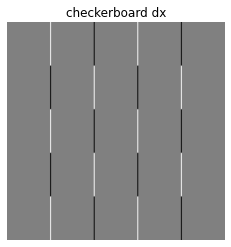

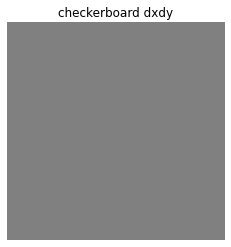

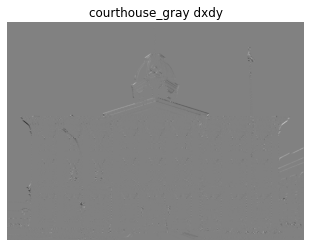

In [13]:
 #Harris Corner Detection

#1.1 Display image derivatives in x, y and dxdy (product of derivatives)

checkerboard.display_image(image = checkerboard.image_dx,title = 'checkerboard dx')
checkerboard.display_image(image = checkerboard.image_dy,title = 'checkerboard dy')
checkerboard.display_image(image = checkerboard.image_dxdy,title = 'checkerboard dxdy')


courthouse_gray.display_image(image = courthouse_gray.image_dx,title = 'courthouse_gray dx')
courthouse_gray.display_image(image = courthouse_gray.image_dy,title = 'courthouse_gray dy')
courthouse_gray.display_image(image = courthouse_gray.image_dxdy,title = 'courthouse_gray dxdy')

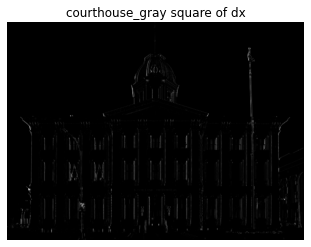

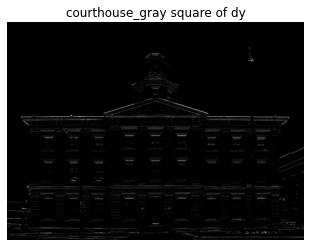

In [14]:
#1.2 Display image derivatives squared in x and y 

checkerboard.display_image(image = checkerboard.image_d2x,title = 'checkerboard square of dx')
checkerboard.display_image(image = checkerboard.image_d2y,title = 'checkerboard square of dy')

courthouse_gray.display_image(image = courthouse_gray.image_d2x,title = 'courthouse_gray square of dx')
courthouse_gray.display_image(image = courthouse_gray.image_d2y,title = 'courthouse_gray square of dy')

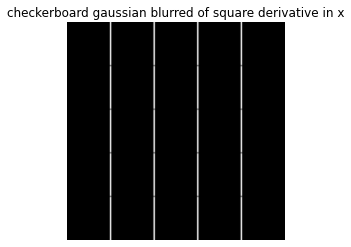

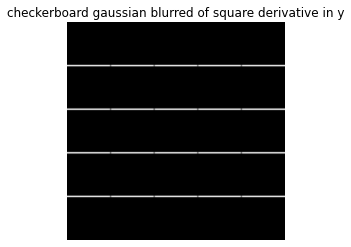

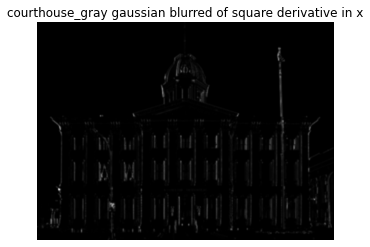

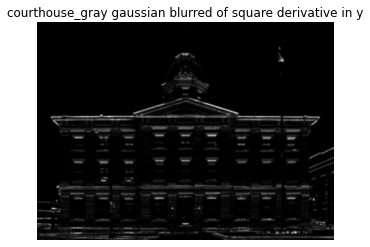

In [15]:
#1.3 Gaussian Filtering of the images in 1.2
checkerboard.display_image(image = checkerboard.gaussian_d2x,title = 'checkerboard gaussian blurred of square derivative in x')
checkerboard.display_image(image = checkerboard.gaussian_d2y,title = 'checkerboard gaussian blurred of square derivative in y')
checkerboard.display_image(image = checkerboard.gaussian_dxdy,title = 'checkerboard gaussian blurred of dxdy')

courthouse_gray.display_image(image = courthouse_gray.gaussian_d2x,title = 'courthouse_gray gaussian blurred of square derivative in x')
courthouse_gray.display_image(image = courthouse_gray.gaussian_d2y,title = 'courthouse_gray gaussian blurred of square derivative in y')
courthouse_gray.display_image(image = courthouse_gray.gaussian_dxdy,title = 'courthouse_gray gaussian blurred of dxdy')

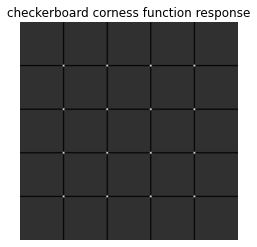

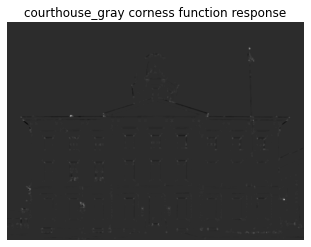

In [16]:
#1.4 Cornernessfunction response: Determinant(H) − kT race(H) 2), where k=0.05.
checkerboard.display_image(image = checkerboard.corness,title = 'checkerboard corness function response')
courthouse_gray.display_image(image = courthouse_gray.corness,title = 'courthouse_gray corness function response')

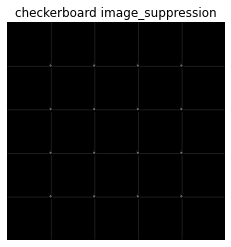

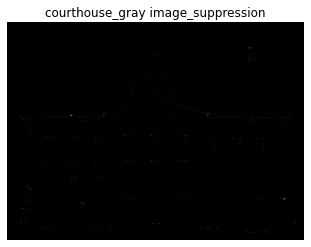

In [17]:
#1.5 Non Maximum suppression (The code to perform this was taken from tutorial 3)
checkerboard.display_image(image = checkerboard.image_suppression,title = 'checkerboard image_suppression')
courthouse_gray.display_image(image = courthouse_gray.image_suppression,title = 'courthouse_gray image_suppression')

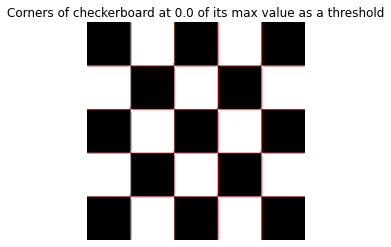

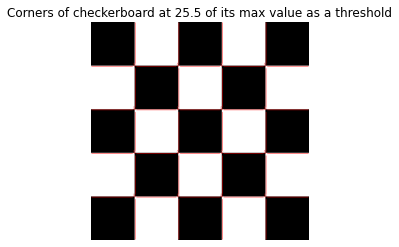

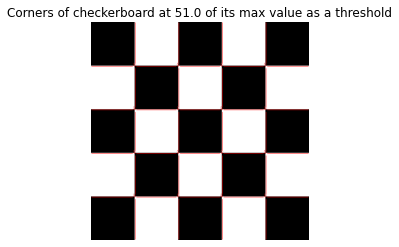

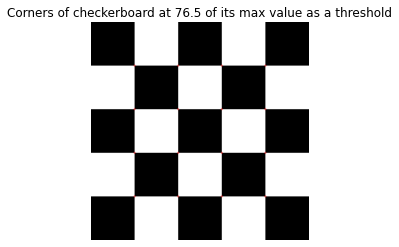

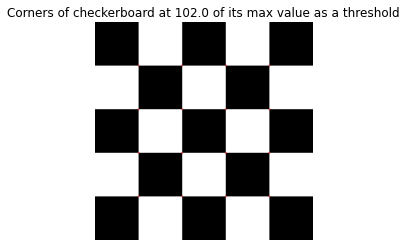

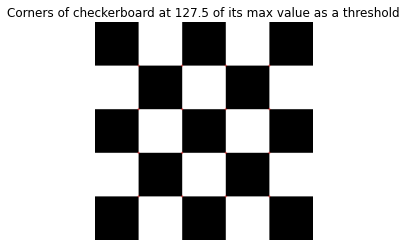

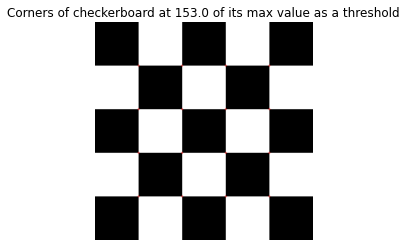

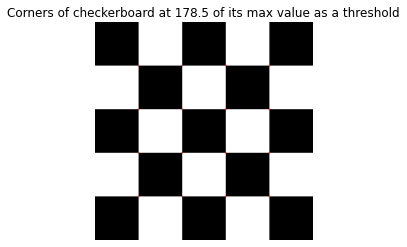

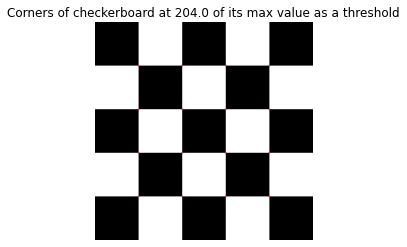

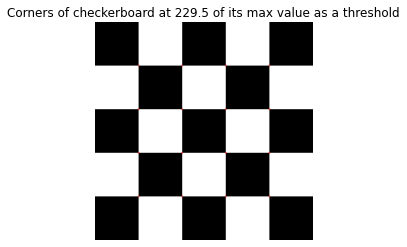

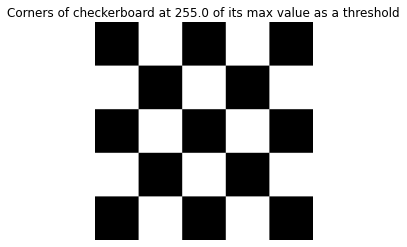

In [18]:
#1.6.1 Different threshold for corner detection on the checkerboard
thresholds = checkerboard.image_suppression.max() * np.arange(11)/10

for thresh in thresholds:
    #Applying thresholds to original image based on suppression and threshold
    
    #Get copy of image
    img_copy = np.copy(checkerboard.image_rgb)
    # Apply the threshold
    img_copy[checkerboard.image_suppression > thresh] = [255, 0, 0]
    
    # Display the thresholded image
    checkerboard.display_image(image=img_copy, title=f'Corners of checkerboard at {thresh} of its max value as a threshold')

# Analysis of the relationship between the threshold used in corner detection and the detected corners on the checkerboard image

#### I applied varying threshold levels to detect corners in the checkerboard image. At a threshold of 75.6, the detected corners align perfectly with the assignment's expected output. Below this value, the algorithm incorrectly identifies the checkerboard's horizontal and vertical gridlines as corners, mistaking the gradient change between black and white squares as genuine corners. When the threshold peaks at 255, the maximum channel value, no corners are discerned. From 75.6 onwards up to, but not including 255, the detected corners remain consistent.


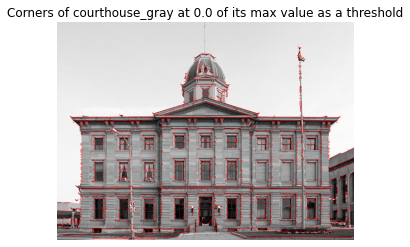

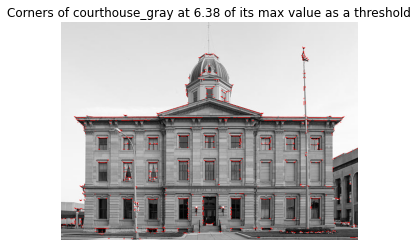

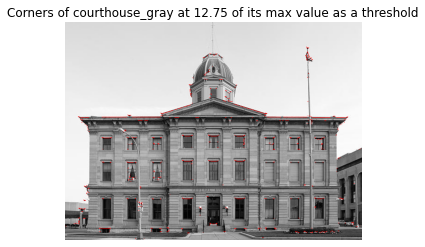

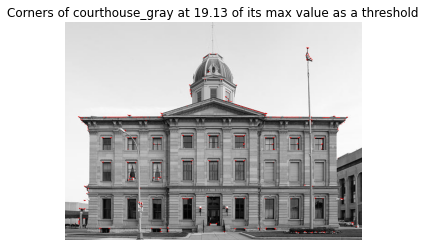

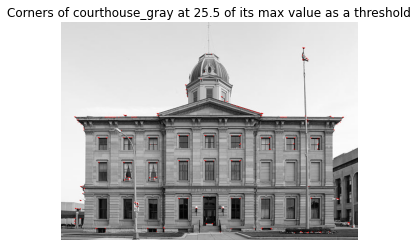

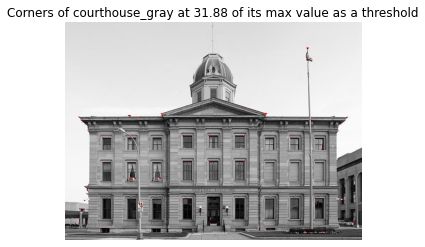

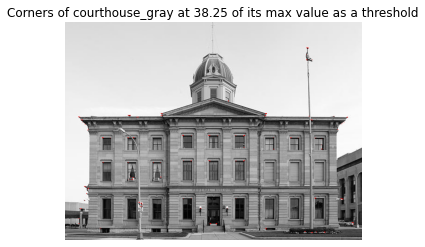

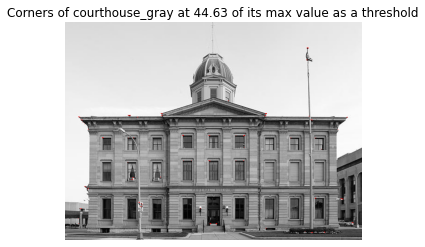

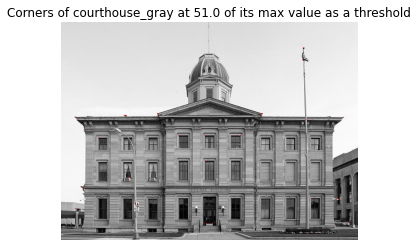

In [19]:
#1.6.2 Corner Detection in the courthouse_gray image

thresholds = courthouse_gray.image_suppression.max() * np.linspace(0,0.2,9)

for thresh in thresholds:
    #Applying thresholds to original image based on suppression and threshold
    
    #Get copy of image
    img_copy = np.copy(courthouse_gray.image_rgb)
    # Apply the threshold
    img_copy[courthouse_gray.image_suppression > thresh] = [255, 0, 0]
    
    # Display the thresholded image
    courthouse_gray.display_image(image=img_copy, title=f'Corners of courthouse_gray at {round(thresh,2)} of its max value as a threshold')


# Analysis of the relationship between the threshold used in corner detection and the detected corners on the courthouse_gray image

#### I experimented with varying threshold levels on the courthouse_gray image for corner detection. As the threshold escalates, fewer corners are pinpointed. The complexity of the image means that the color gradient at genuine corners might not be sharply contrasting, complicating corner detection. A lower threshold, while potentially misidentifying non-corners, ensures that actual corners aren't overlooked. This balance between precision and recall poses a challenge in optimizing corner detection for this intricate image.


In [20]:
#Part 2 Reuses Images from Assignment 1

my_image_1 = Image(image_path = PATH + "image_1.jpg", image_name = 'my_image_1', non_max_suppression = False)
my_image_2 = Image(image_path = PATH + "image_2.jpg", image_name = 'my_image_2', non_max_suppression = False)

#Set picture RGB
my_image_1.image_rgb = cv2.cvtColor(my_image_1.image, cv2.COLOR_BGR2RGB)
my_image_1.image = my_image_1.image_rgb
my_image_2.image_rgb = cv2.cvtColor(my_image_2.image, cv2.COLOR_BGR2RGB)
my_image_2.image = my_image_2.image_rgb

# The four main actions (steps) of the SIFT method are:

#### 1. Generate a Scale-Space Image Pyramid
#### 2. SIFT key localization (feature detection)
#### 3. Eliminable unstable/noisy keypoints
#### 4. Select canonical orientation for the SIFT key

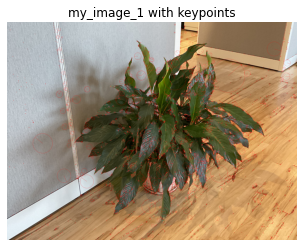

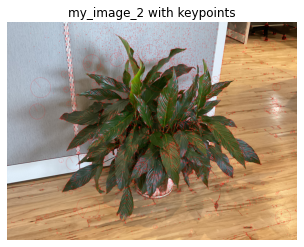

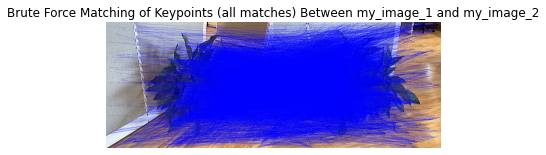

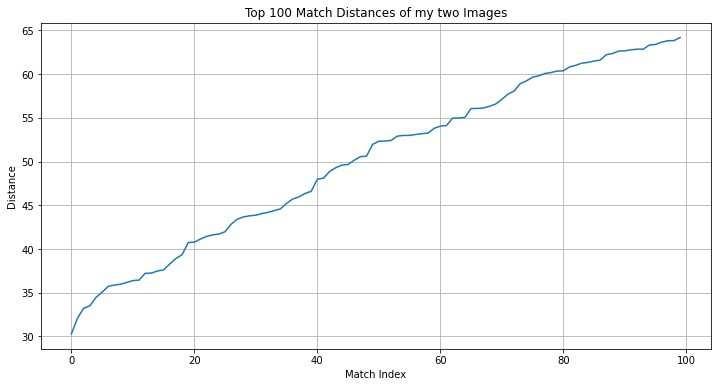

In [21]:
#2.2 SIFT between two different pictures

my_image_1.compute_and_display_keypoints()
my_image_2.compute_and_display_keypoints()

#Match all keypoints between the two images using brute-force method and display the matches
All_matches = my_image_1.brute_force_match(other_image = my_image_2)

#Sort the matching keypoints to by matching distances and display top 100
my_image_1.brute_force_match(other_image = my_image_2, top_matches = 100)


#Plot top 100 matches distances
x_axis = np.arange(len(All_matches[:100]))
y_axis = [match.distance for match in All_matches[:100]]
   
#Actual plotting
plt.figure(figsize=(12, 6))
plt.plot(x_axis, y_axis)  # You can use 'marker' to highlight each point
plt.title('Top 100 Match Distances of my two Images')
plt.xlabel('Match Index')
plt.ylabel('Distance')
plt.grid(True)  # Adding a grid for better readability
plt.show()

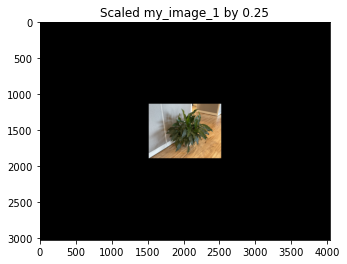

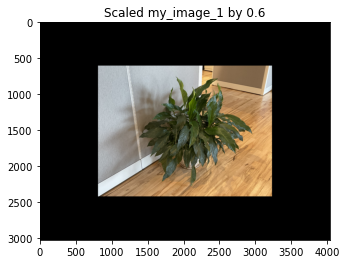

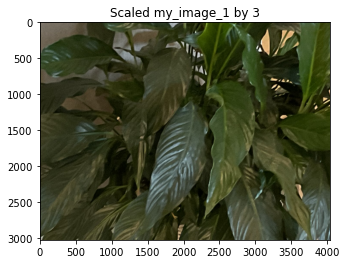

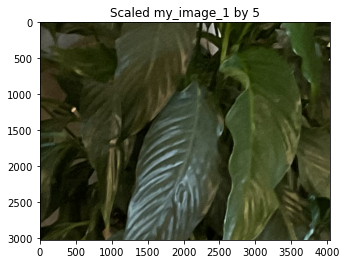

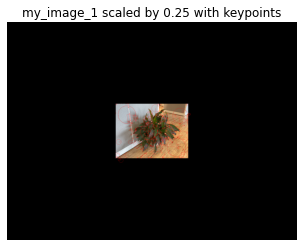

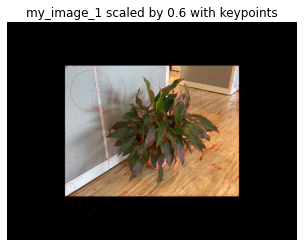

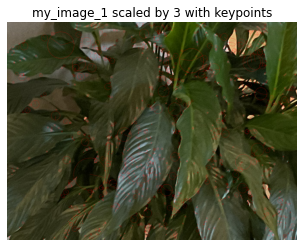

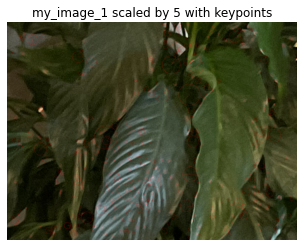

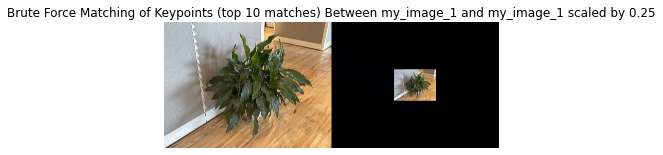

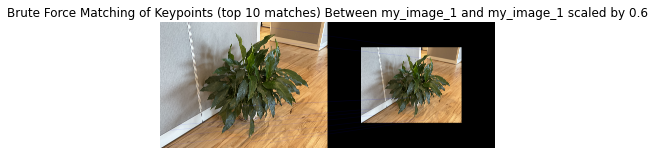

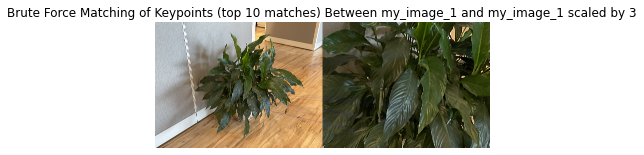

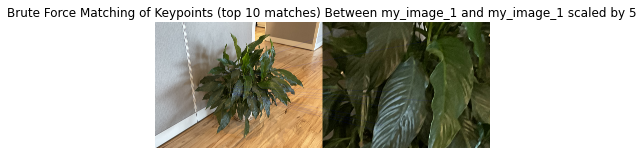

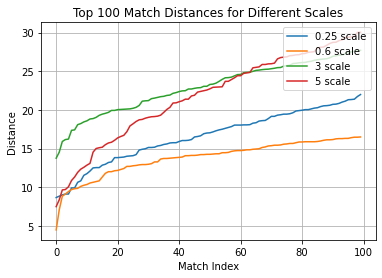

In [22]:
#2.3 Invariance Under Scale

#Scale Factors given in 2.3.3 take too

#The key points of my_image_1 were already computed in the previous section
keypoints,descriptors = my_image_1.keypoints, my_image_1.descriptors
scaling_factors = [0.25, 0.6, 3, 5]
scaled_images = []

for scaling in scaling_factors:
    #Display scaled images and create image object with them
    Scaled_Image = Image(image_path = my_image_1.scale_image(scale = scaling), image_name = my_image_1.image_name + f' scaled by {scaling}')
    Scaled_Image.image_rgb = Scaled_Image.image
    scaled_images.append(Scaled_Image)

#Compute SIFT keypoints of scaled images and display them
for image in scaled_images:
    image.compute_and_display_keypoints(display_keypoints=True)
    #Display RGB of image with keypoints
    #image.display_image(image = cv2.cvtColor(image.image_keypoints, cv2.COLOR_BGR2RGB), title = f'{image.image_name} with keypoints')


#Get top 10 matches between original image_1 and all of its scaled counterparts
#Display all of these matches
matches = []
for image in scaled_images:
    matching = my_image_1.brute_force_match(other_image = image, top_matches = 10)
    matches.append([[match.distance for match in matching[:100]]])
 
# Looping through matches and plotting distances for 100 top matches for all scales
for i, match in enumerate(matches):
    x_axis = np.arange(len(matches[i][0]))
    y_axis = [distance for distance in match][0]

    # Plotting without displaying
    plt.plot(x_axis, y_axis, label=f'{scaling_factors[i]} scale')  # Added label for the legend

# Configuring the plot
plt.title('Top 100 Match Distances for Different Scales')
plt.xlabel('Match Index')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(loc='upper right')  # Displaying the legend

# Displaying the final plot
plt.show()


#  Analysis of trends between distance of keypoints in original image and scaled images with respect to the scaling factor

##### Comparing the distances between the top 100 matching keypoints of an original image and its scaled versions, four distinct scales were considered. Intriguingly, as the scaling factor increased, there was a correspondingly accelerated growth in the keypoint matching distances, suggesting a widening disparity in feature matches as the image was upscaled. However, a notable exception to this trend was observed at the smallest scale of 0.25. At this scale, the growth in matching distances was more gradual, exhibiting a slower rate than its larger-scaled counterparts.  This could imply a higher similarity or resilience in keypoint matching at this reduced scale compared to more magnified versions.

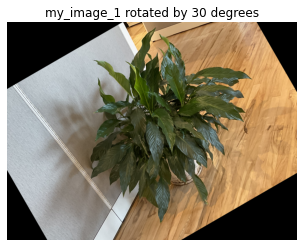

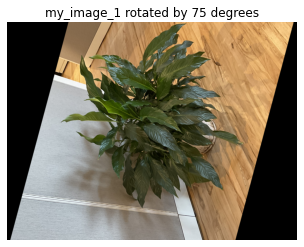

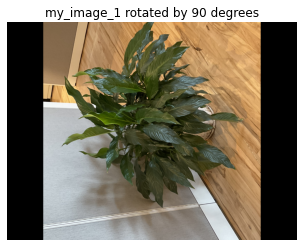

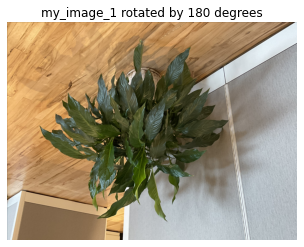

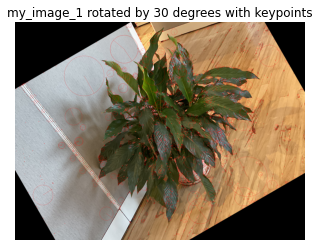

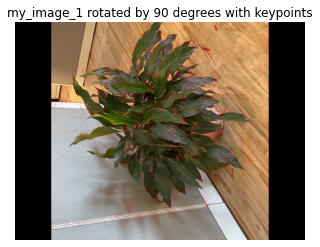

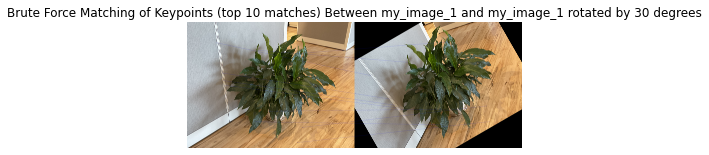

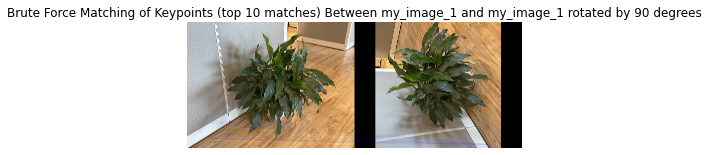

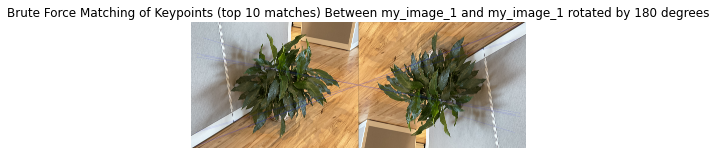

In [23]:
#2.4 Invariance Under Rotation

#Rotating image at the angle of (30,75,90,180) and display images

angles = [30,75,90,180]

rotated_images = []
for angle in angles:
    rotated_image = my_image_1.rotate_image(angle = angle)
    rotated_images.append(rotated_image)
    rotated_image.display_image()


#Display SIFT of rotated images

for image in rotated_images:
    image.compute_and_display_keypoints(display_keypoints=True)
    

#Match Keypoints of rotated image to original image using brute force method
#Display 10 best keypoints

matches = []
for image in rotated_images:
    matching = my_image_1.brute_force_match(other_image = image, top_matches = 10)
    matches.append([[match.distance for match in matching[:100]]])
 

#Plot matching distance with rotation

# Looping through matches and plotting distances for 100 top matches for all scales
for i, match in enumerate(matches):
    x_axis = np.arange(len(matches[i][0]))
    y_axis = [distance for distance in match][0]

    # Plotting without displaying
    plt.plot(x_axis, y_axis, label=f'{angles[i]} degrees rotation')  # Added label for the legend

# Configuring the plot
plt.title('Top 100 Match Distances for Different Scales')
plt.xlabel('Match Index')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(loc='upper right')  # Displaying the legend

# Displaying the final plot
plt.show()

# Analysis of trend in distance between matched keypoints and rotation angles

#### By analyzing the rotation angle versus the distance between matching keypoints, we can see. That increasing the angle increases the distance of each keypoints up until a certain angle, in this case 90 degrees, is reached. From there, we see that the distance between keypoints Is all set to 0. The same happens at a rotation of 180 degree, which is why the 90 degree distance line is not seen in my plot as it is superposed by the 180 degree one. The 90 and 180 rotation angles keep the image in its entirety in the frame which allows all original 100 best keypoints to be matched. The other angle lose part of the image's information which makes the matching more complex and reduces its accuracy.

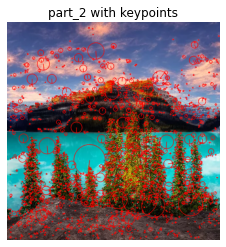

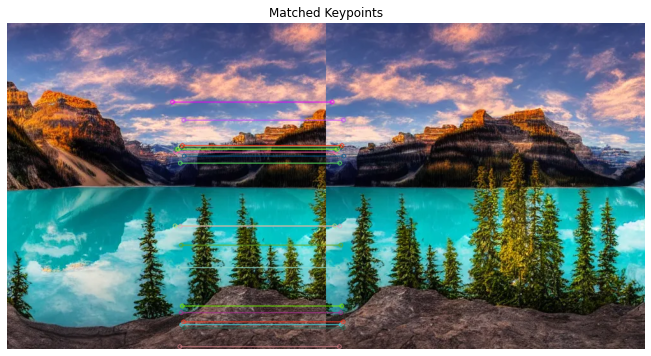

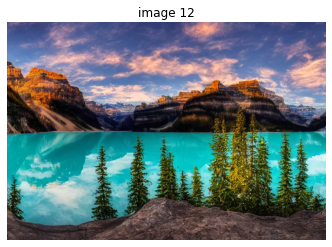

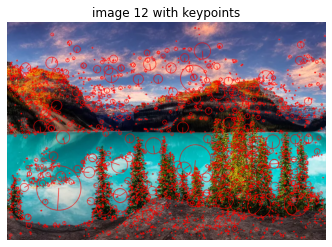

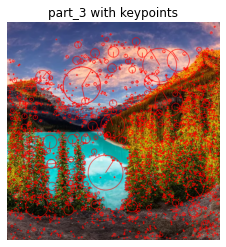

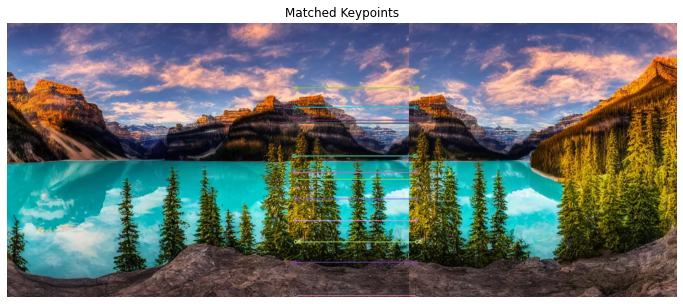

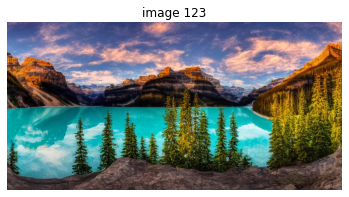

In [26]:
#Part 3

image_1 = Image(image_path = PATH + "Data/Q3/part1.png", image_name = 'part_1')
image_2 = Image(image_path = PATH + "Data/Q3/part2.png", image_name = 'part_2')
image_3 = Image(image_path = PATH + "Data/Q3/part3.png", image_name = 'part_3')

#Set RGB for images
image_1.image = image_1.image_rgb
image_2.image = image_2.image_rgb
image_3.image = image_3.image_rgb

#Display part1 and part2 SIFT Keypoints and stitch to get image12
image_12 = image_1.stitch_and_blend(other_image = image_2, title_stitched = 'image 12')

#Display Stitched Image_12
image_12.display_image(image = image_12.image)

#Display image12 and part3 SIFT Keypoints and stitch to get image123

image_123 = image_12.stitch_and_blend(other_image = image_3, title_stitched = 'image 123')
#image_123.image = image_123.image_rgb

#Display Stitched Image_123
image_123.display_image(image = image_123.image)

# We also could have used multi-band blending instead of linear blending. When should one prefer pyramid blending over linear blending

#### Linear blending is easy to implement by its simple computations which results in lower time complexity than pyramid blending. However, parameter fine tuning such as the threshold in linear blending can be computationally expensive to optimize.

#### Pyramid blending provides better smoothing for images at any frequency.  Its implementation is more complex than linear blending as it involves building multiple Laplacian layers. These operation yield a high space and time complexity. Given enough resources, pyramid blending yields a higher quality of blending at the cost of being computationally expensive. Linear blending is preferred when the quality of the blend does not necessarily need to be of high quality, and the blend needs to be computed in minimal time.